In [1]:
# initialize accelerator and trackers (if enabled)
from os import makedirs, path, scandir
import pickle
import cv2
import json
from yacs.config import CfgNode as CN
from torch.utils.data import Dataset
from tqdm import tqdm
import logging
import random
import torch
# from src.datasets import FFPP,RPPG
from accelerate import Accelerator
from main import get_config, init_accelerator, set_seed, FFPP
logging.basicConfig(level="DEBUG")


class Obj:
    pass


c = FFPP.get_default_config()
c.augmentation = "normal+frame"
c.pair = 1
# c.contrast = 1
c.compressions = ["c23"]
# c.types = ["REAL", "DF", "FS", "F2F"]
c.types = ["DF", "FS", "F2F"]
accelerator = Accelerator(mixed_precision='no')
x = FFPP(c, 20, 5, lambda x: x, accelerator, split="train")
c

/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3/3 [00:00<00:00, 2801.81it/s]


CfgNode({'category': 'train', 'root_dir': './datasets/ffpp/', 'detection_level': 'video', 'types': ['DF', 'FS', 'F2F'], 'compressions': ['c23'], 'name': 'FFPP', 'scale': 1.0, 'pack': 0, 'pair': 1, 'contrast': 0, 'augmentation': ['normal', 'frame'], 'random_speed': 1})

In [2]:
typ, cmp, idx, _ = x.video_list[0]
x.video_table[typ][cmp][idx]

{'fps': 30,
 'frames': 453,
 'duration': 15.1,
 'path': './datasets/ffpp/DF/c23/videos/071_054.avi'}

In [3]:
# a = x.get_dict(7079, True)

In [4]:
len(x)

6513

In [14]:
frames, label, mask, _, _ = x[random.randint(0, len(x))]
(len(frames), label, len(mask))

DEBUG:root:Item/Video Index:1286/387
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 0.905891383238375
DEBUG:root:Video Shift Factor: 0.05705393030447682
DEBUG:root:Loading Video: ./datasets/ffpp/DF/raw/videos/060_088.avi
DEBUG:root:Sample Offset: 25
DEBUG:root:Sample Stride: 0.23578947368421052
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Downscale Ratio: 1
DEBUG:root:Video: ./datasets/ffpp/DF/raw/videos/060_

(2, 1, 20)

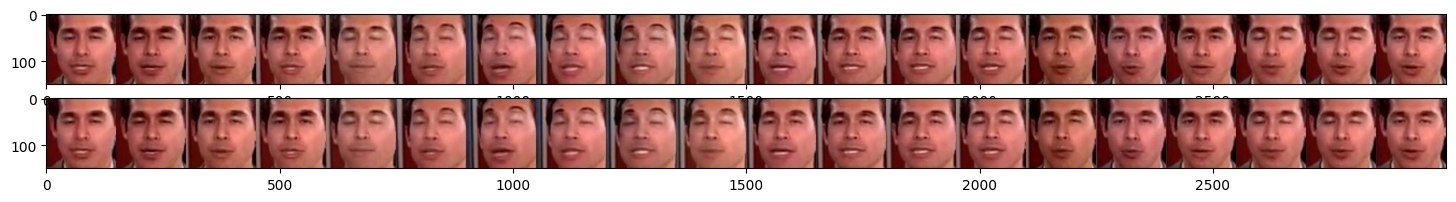

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 2))
plt.subplot(2, 1, 1)
plt.imshow(
    np.stack(
        frames["raw"][:30].numpy().transpose((0, 2, 3, 1)), axis=1
    ).reshape((150, -1, 3))
)
plt.subplot(2, 1, 2)
plt.imshow(
    np.stack(
        frames["c23"][:30].numpy().transpose((0, 2, 3, 1)), axis=1
    ).reshape((150, -1, 3))
)

In [ ]:
# for i in tqdm(range(len(x))):
#     try:
#         x[i]
#     except Exception as e:
#         print(f"Error Occur at {i}:{e}")